# Python interface

## Step 1: creating the **spinfoam** shared library

Let's start importing the *spinfoam.py* module 

In [70]:
import spinfoam as sf

We clean all the previous executable and object files, along with the corresponding folders

In [2]:
sf.spinfoam_clean()

rm -rf obj
rm -rf lib
rm -rf bin


If all dependencies are satisifed, the following cell should compile and build all the required files.

Notice that you can also compile in debug mode with **spinfoam_compile_debug()**

In [71]:
sf.spinfoam_compile()

make: Nessuna operazione da eseguire per «default».


## Step 2: Hashing tables of 21j Wigner symbols 

Now we compute the hash tables with 21j Wigner symbols, which will be retrieved during the next step.
These tables are, in fact, a key ingredient for the Metropolis-Hastings algorithm which we implement in step 3.

For the calculation, we use the _wigxjpf_ and _fastwigxj_ libraries [Johansson et al., 2015].
For ease of use, all the necessary hash tables of 3j, 6j and 9j Wigner symbols have been previously computed and stored in `./ext/fastwig_tables/`.

We use the [parallel hashmap](https://github.com/greg7mdp/parallel-hashmap) in order to store the 21j Wigner symbols hash tables. 

In [72]:
# this is the folder with the pre-computed hash tables of 3j, 6j and 9j Wigner symbols. 
# Jupyter kernel dies if tables are not found (C function returns "EXIT FAILURE")
fastwig_tables_path = "./ext/fastwig_tables"

# this is the folder in which we decide to store the computed hash tables of 21j symbols
hash_tables_path = "./ext/hashed_21j"

# value of all boundary spins of the spinfoam
spin = 0.5

In [73]:
sf.Hashing_21j_symbols(hash_tables_path, fastwig_tables_path, spin)

Hashing all 21j symbols with j <= 0.5...
Completed! The hash table has been stored


## Step 3: Metropolis-Hastings run

We can finally compute and assemble the Markov chains by running the MH algorithm. The computed draws are stored in the given folder.

We run in parallel an independent Markov chain for each provided thread.

Each thread retrieves from the 21j hash table (computed in step 2) the required symbol, according to the position in the spins configuration space

In [74]:
# this is the folder in which we decide to store the draws
draws_path = "./data_folder/collected_draws"

# this is the folder with the pre-computed hash tables of 21j Wigner symbols (see Step 2). 
# Jupyter kernel dies if tables are not found (C function returns "EXIT FAILURE")
hash_tables_path = "./ext/hashed_21j"

# MH parameters
spin = 2
length = 1000
sigma = 0.4
burnin = 10 
verbosity = 0 

# set optimal number of threads
import multiprocessing
number_of_threads = int(multiprocessing.cpu_count())

In [75]:
number_of_threads

12

In [76]:
sf.Metropolis_Hastings_parallel_run(draws_path, hash_tables_path, spin, length, sigma, burnin, verbosity, number_of_threads)

Starting 12 independent Markov chains...
Completed! All draws have been stored


# Plots

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
import pandas as pd
import numpy as np

# Setting plot style

sns.set()
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.0})

rc('text', usetex=True)

sns.set_style("ticks")
sns.set_style("whitegrid", 
 {'axes.edgecolor': 'black',
 'axes.grid': True,
 'axes.axisbelow': True,
 'axes.labelcolor': '.15',
 'grid.color': '0.9',
 'grid.linestyle': '-',
 'xtick.direction': 'in', 
 'ytick.direction': 'in',
 'xtick.bottom': True,
 'xtick.top': True,
 'ytick.left': True,
 'ytick.right': True, 
 'font.family': ['sans-serif'],
 'font.sans-serif': [
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],})

## Loglog plot (with fit) of hash tables size

We want to understand how fast the size of 21j Wigner symbols hash tables increases as a function of boundary spin j

In [13]:
size_hash_tables_in_MB = [12.8e-03, 409.5e-03, 6.55, 52.42, 209.71, 838.86, 3.35e+03, 6.71e+03]
corresponding_spin = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]

# fit log(size) = m*log(j) + c
m, c = np.polyfit(np.log(corresponding_spin), np.log(size_hash_tables_in_MB), 1, w=np.sqrt(size_hash_tables_in_MB)) 
size_fit = np.exp(m*np.log(corresponding_spin) + c) 

df = pd.DataFrame({
   "spin" : corresponding_spin,
   "table_size" : size_hash_tables_in_MB,
   "fitted_data" : size_fit
    })

In [14]:
df

,spin,table_size,fitted_data
0,0.5,0.0128,0.004545
1,1.0,0.4095,0.526787
2,1.5,6.5500,8.492613
3,2.0,52.4200,61.053381
4,2.5,209.7100,281.963782
5,3.0,838.8600,984.273892
6,3.5,3350.0000,2832.373455
7,4.0,6710.0000,7075.943061


In [15]:
from matplotlib.ticker import ScalarFormatter

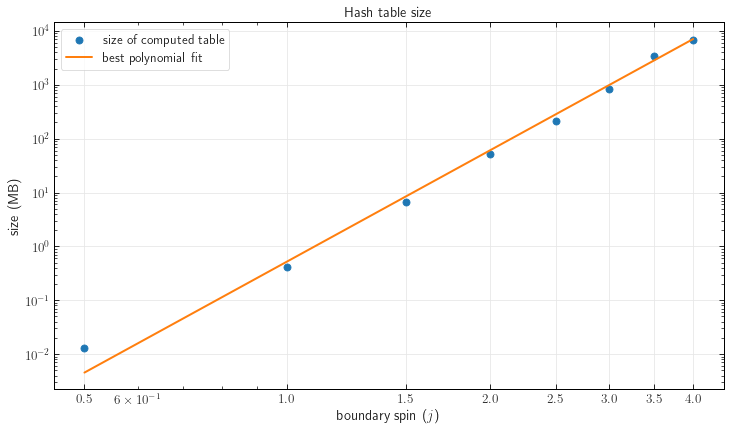

In [16]:
ax = df.plot(x='spin', y='table_size', s=50, xticks = corresponding_spin, 
             kind='scatter', grid='false', color='tab:blue', label='size of computed table',
             logy=True, logx=True, figsize=(12,6.75))
df.plot(x='spin', y='fitted_data', ax=ax, kind='line', color='tab:orange', label='best polynomial fit')
plt.ylabel("size (MB)")
plt.xlabel("boundary spin ($j$)")
plt.title('Hash table size')
ax.xaxis.set_major_formatter(ScalarFormatter())


plt.show()

We conclude that the size of the 21j Wigner symbols roughly increases as: 

$$ \text{Size(j)} \approx j^{6.86} - 0.64$$

In [1]:
# Import packages
import os

import matplotlib.pyplot as plt
import pandas as pd

In [15]:
df = pd.read_csv("/home/frisus95/Scrivania/Final_project/data_folder/collected_draws/j_1/N_1000000__sigma_0.38__burnin_10_chain_2.csv")


/tmp/ipykernel_6000/862961188.py:1: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/home/frisus95/Scrivania/Final_project/data_folder/collected_draws/j_1/N_1000000__sigma_0.38__burnin_10_chain_2.csv")


In [16]:
df

,intertwiner 1,intertwiner 2,intertwiner 3,intertwiner 4,intertwiner 5,intertwiner 6,intertwiner 7,intertwiner 8,intertwiner 9,intertwiner 10,...,intertwiner 12,intertwiner 13,intertwiner 14,intertwiner 15,intertwiner 16,draw multeplicity,draw amplitude,total accept. draws,total accept. rate,total run time
0,0,0,2,2,2,2,1,0,0,1,...,0,1,1,1,0,9,1.031220e-06,204827.0,31%,43.5915 s
1,1,0,2,2,1,2,0,0,0,1,...,0,1,1,0,1,7,1.117630e-06,NaN,NaN,NaN
2,1,0,2,2,1,2,0,0,0,1,...,0,2,1,0,1,3,-2.597140e-06,NaN,NaN,NaN
3,1,0,2,2,1,2,0,0,0,0,...,0,2,0,0,1,15,-2.444370e-06,NaN,NaN,NaN
4,1,0,2,2,1,2,1,0,0,0,...,0,2,0,0,1,7,1.587660e-06,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204822,1,1,2,1,1,0,2,0,2,0,...,2,2,0,0,1,7,3.552750e-07,NaN,NaN,NaN
204823,1,0,2,1,1,0,2,0,2,0,...,2,2,0,0,2,3,9.319160e-07,NaN,NaN,NaN
204824,1,0,2,1,0,0,2,0,2,0,...,2,1,0,0,2,7,6.832220e-07,NaN,NaN,NaN
204825,2,0,2,1,0,0,2,0,2,0,...,2,1,0,0,2,7,-4.116170e-07,NaN,NaN,NaN


In [ ]:
for i, j in df.iterrows():
    print(i, j)
    print()

In [17]:
total_rows = len(df)

In [18]:
total_rows

204827

In [19]:
columns = list(df)

In [20]:
columns

['intertwiner 1',
 'intertwiner 2',
 'intertwiner 3',
 'intertwiner 4',
 'intertwiner 5',
 'intertwiner 6',
 'intertwiner 7',
 'intertwiner 8',
 'intertwiner 9',
 'intertwiner 10',
 'intertwiner 11',
 'intertwiner 12',
 'intertwiner 13',
 'intertwiner 14',
 'intertwiner 15',
 'intertwiner 16',
 'draw multeplicity',
 'draw amplitude',
 'total accept. draws',
 'total accept. rate',
 'total run time']

In [21]:
for i in columns:

    # printing the third element of the column
    print(df[i][1])


1
0
2
2
1
2
0
0
0
1
0
0
1
1
0
1
7
1.11763e-06
nan
nan
nan


In [10]:
df['intertwiner 1'][10]

1

In [35]:
angle = 0.0

for i in range(total_rows):
    angle += (((df['intertwiner 1'][i]) *
               (df['intertwiner 1'][i] + 1) - 2 * 1 * (1 + 1)) /
              (2 * 1 * (1 + 1))) * df['draw multeplicity'][i]


In [37]:
angle / (1000000 - 10)


-0.3263537635376354

In [38]:
"N_1000000__sigma_0.38__burnin_10_chain_1.csv"

'N_1000000__sigma_0.38__burnin_10_chain_1.csv'

In [52]:
prefix = "troiazza/lezza"

In [44]:
os.path.isfile("/home/frisus95/Scrivania/Final_project/data_folder/collected_draws/j_1/N_1000000__sigma_0.38__burnin_10_chain_1.csv")

True

In [48]:
chain_id = 1

In [77]:
stuff_in_string = f"{prefix}/N_{length}__sigma_{sigma}__burnin_{burnin}_chain_{chain_id}.csv"
print(stuff_in_string)

troiazza/lezza/N_1000__sigma_0.4__burnin_10_chain_1.csv


In [103]:
import warnings
warnings.warn(f"Warning..........Message")

/tmp/ipykernel_6000/1910235401.py:2: UserWarning: Warning..........Message
  warnings.warn(f"Warning..........Message")


In [115]:
import warnings

def custom_formatwarning(msg, *args, **kwargs):
    # ignore everything except the message
    return str(msg) + '\n'

warnings.formatwarning = custom_formatwarning

In [118]:
def funza(draws_folder, spin, length, sigma, burnin, number_of_chains_to_process):
    for chain_id in range(1,number_of_chains_to_process+1):
      stringa = f"{draws_folder}/j_{spin}/N_{length}__sigma_{sigma}__burnin_{burnin}_chain_{chain_id}.csv"
      if (os.path.isfile(stringa)):
        print(f"esiste per chain_id {chain_id}")
      else:
        warnings.warn("Warning: chain id %d not found" % (chain_id))

In [119]:
funza(draws_path, spin, length, sigma, burnin, 1)

esiste per chain_id 1


In [120]:
def gunza(csv_file_path, spin):
    df = pd.read_csv(csv_file_path)

In [121]:
pd.read_csv("/home/frisus95/Scrivania/Final_project/data_folder/collected_draws/j_1/N_1000000__sigma_0.38__burnin_10_chain_1.csv")

Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.


,intertwiner 1,intertwiner 2,intertwiner 3,intertwiner 4,intertwiner 5,intertwiner 6,intertwiner 7,intertwiner 8,intertwiner 9,intertwiner 10,...,intertwiner 12,intertwiner 13,intertwiner 14,intertwiner 15,intertwiner 16,draw multeplicity,draw amplitude,total accept. draws,total accept. rate,total run time
0,0,0,2,2,2,2,1,0,0,1,...,0,1,1,1,0,9,1.031220e-06,204827.0,31%,44.45 s
1,1,0,2,2,1,2,0,0,0,1,...,0,1,1,0,1,7,1.117630e-06,NaN,NaN,NaN
2,1,0,2,2,1,2,0,0,0,1,...,0,2,1,0,1,3,-2.597140e-06,NaN,NaN,NaN
3,1,0,2,2,1,2,0,0,0,0,...,0,2,0,0,1,15,-2.444370e-06,NaN,NaN,NaN
4,1,0,2,2,1,2,1,0,0,0,...,0,2,0,0,1,7,1.587660e-06,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204822,1,1,2,1,1,0,2,0,2,0,...,2,2,0,0,1,7,3.552750e-07,NaN,NaN,NaN
204823,1,0,2,1,1,0,2,0,2,0,...,2,2,0,0,2,3,9.319160e-07,NaN,NaN,NaN
204824,1,0,2,1,0,0,2,0,2,0,...,2,1,0,0,2,7,6.832220e-07,NaN,NaN,NaN
204825,2,0,2,1,0,0,2,0,2,0,...,2,1,0,0,2,7,-4.116170e-07,NaN,NaN,NaN


In [163]:
import numpy as np
import timeit 

In [122]:
total_rows = len(df)
columns = list(df)

In [167]:
angles_array = np.zeros((16, total_rows))

import time 

tic = time.time()

for j in range(0,16):
  for i in range(total_rows):
    intertwiner = df[f'intertwiner {j+1}'][i] 
    multeplicity = df['draw multeplicity'][i]
    angles_array[j,i] += ((intertwiner*(intertwiner + 1) - 2*spin*(spin + 1))/(2*spin*(spin + 1)))*multeplicity

toc = time.time()

print("Time Elapsed: ", toc - tic)


Time Elapsed:  26.526599407196045


In [158]:
angles_array[0,0:100]

array([ -9.        ,  -5.83333333,  -2.5       , -12.5       ,
        -5.83333333,  -5.        ,  -6.66666667,  -0.83333333,
        -0.83333333, -13.33333333, -22.5       , -14.16666667,
        -9.16666667,  -3.33333333,  -4.        ,  -1.        ,
        -1.        ,  -1.        ,  -7.        ,  -1.        ,
        -8.        ,  -2.        ,  -5.        ,  -3.        ,
        -4.        , -11.        ,  -4.        ,  -2.        ,
        -8.        ,  -4.        ,  -9.        ,  -7.        ,
        -1.        ,  -4.        ,  -1.        , -11.        ,
        -3.        , -10.        ,  -3.        ,  -3.        ,
        -5.        ,  -1.        , -13.        ,  -4.        ,
        -9.        , -10.        ,  -3.        ,  -2.        ,
        -6.        ,  -3.        ,  -6.        ,  -1.        ,
        -1.        ,  -2.        , -24.        , -16.        ,
        -1.        ,  -5.        ,  -5.        ,  -5.        ,
       -22.        ,  -8.        ,  -6.        ,  -1.  

In [159]:
angles_array = np.zeros((10, 10))

In [160]:
angles_array

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [148]:
angles_array[0,0]

0.0